In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout,LSTM
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


In [20]:

df = pd.read_csv("global_inflation_data.csv")  

df_melted = df.melt(id_vars=["country_name", "indicator_name"], var_name="year", value_name="inflation_rate")
df_melted.drop(columns=["indicator_name"], inplace=True)
df_melted["year"] = df_melted["year"].astype(int)

df_melted["inflation_rate"] = df_melted.groupby("country_name")["inflation_rate"].transform(lambda x: x.interpolate().bfill().ffill())


In [21]:
Q1 = df_melted["inflation_rate"].quantile(0.25)
Q3 = df_melted["inflation_rate"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_melted["inflation_rate"] = df_melted["inflation_rate"].clip(lower_bound, upper_bound)


In [22]:
df_melted["inflation_rate"] = df_melted.groupby("country_name")["inflation_rate"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

In [23]:
df_melted["inflation_rate"].replace([np.inf, -np.inf], np.nan, inplace=True)

df_melted["inflation_rate"].fillna(method="bfill", inplace=True)
df_melted["inflation_rate"].fillna(method="ffill", inplace=True)  

df_melted["inflation_rate"] = df_melted["inflation_rate"].clip(lower=df_melted["inflation_rate"].quantile(0.01),
                                                               upper=df_melted["inflation_rate"].quantile(0.99))

scaler = MinMaxScaler(feature_range=(0,1))
df_melted["inflation_rate"] = scaler.fit_transform(df_melted[["inflation_rate"]])


In [24]:
df_melted["country_code"] = LabelEncoder().fit_transform(df_melted["country_name"])
df_melted["prev_year"] = df_melted.groupby("country_name")["inflation_rate"].shift(1)
df_melted["prev_year"].fillna(df_melted["inflation_rate"], inplace=True)


In [27]:


sequence_length = 10
X_all, y_all = [], []
for country in df_melted["country_name"].unique():
    country_data = df_melted[df_melted["country_name"] == country]
    for i in range(len(country_data) - sequence_length):
        X_all.append(country_data.iloc[i:i+sequence_length][["inflation_rate", "prev_year", "country_code"]].values)
        y_all.append(country_data.iloc[i+sequence_length]["inflation_rate"])
X_all, y_all = np.array(X_all), np.array(y_all)

train_size = int(0.8 * len(X_all))
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]



In [28]:

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])


Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0683 - val_loss: 0.1008
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0363 - val_loss: 0.0515
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0226 - val_loss: 0.0496
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0175 - val_loss: 0.0237
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0132 - val_loss: 0.0079
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0113 - val_loss: 0.0057
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 8/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0075 - val_loss: 0.0234
Epoch 9/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0068 - val_loss: 0.0088
Epoch 10/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 11/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 12/100
172/172 ━━━━━━━━━

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Absolute Error (MAE): 0.04392470918885798
Root Mean Squared Error (RMSE): 0.06440374906629992


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


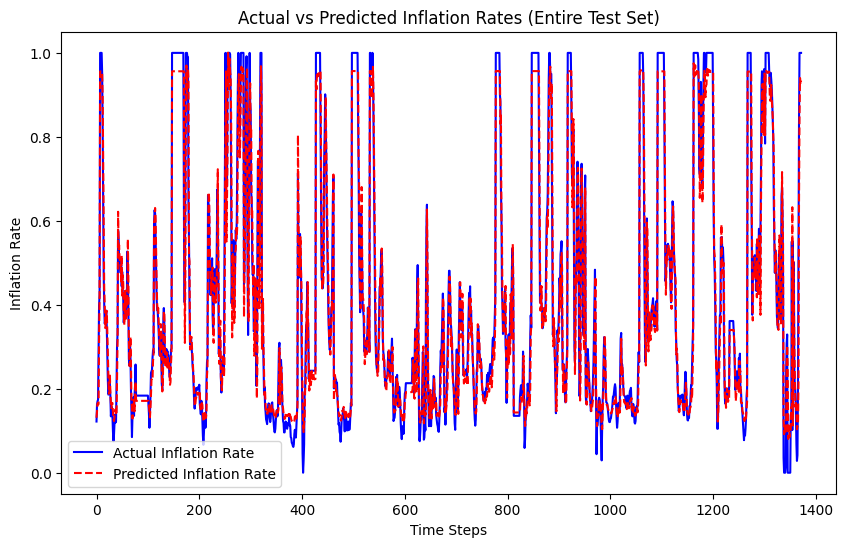

In [52]:
import matplotlib.pyplot as plt

y_pred_all = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Inflation Rate', color='blue')
plt.plot(y_pred_all, label='Predicted Inflation Rate', color='red', linestyle='--')
plt.title("Actual vs Predicted Inflation Rates (Entire Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Inflation Rate")
plt.legend()
plt.show()
